In [1]:
# GNN 기반 영화 추천 시스템
# MacBook Pro M4 16GB 최적화 버전

import os
import pickle
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 60)
print("환경 설정")
print("=" * 60)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"MPS 사용 가능: {torch.backends.mps.is_available()}")
print("=" * 60)

환경 설정
PyTorch 버전: 2.9.0
CUDA 사용 가능: False
MPS 사용 가능: True


In [2]:
# 하이퍼파라미터 설정 (V2 - Improved)
CONFIG = {
    # Split 비율
    'train_ratio': 0.7,
    'valid_ratio': 0.1,
    'test_ratio': 0.2,
    
    # 모델 파라미터
    'embedding_dim': 128,      # 64 → 128 (더 풍부한 표현)
    'n_layers': 2,             # LightGCN 레이어 수
    
    # 학습 파라미터
    'learning_rate': 0.0005,   # 0.001 → 0.0005 (더 안정적)
    'weight_decay': 1e-5,      # L2 regularization 추가
    'batch_size': 1024,        # 2048 → 1024 (더 stable gradient)
    'epochs': 100,
    'patience': 15,            # 10 → 15 (더 오래 기다림)
    'neg_ratio': 2,            # 1 → 2 (더 많은 negative samples)
    
    # 평가
    'top_k': 10,               # Top-K 추천
    
    # Rating threshold (V2 핵심 개선!)
    'rating_threshold': 4.0,   # ≥4.0만 positive로 사용
    
    # 시스템
    'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    'seed': 42,
    
    # 경로
    'data_dir': '../data',
    'processed_dir': '../data/processed',
    'model_dir': '../models',
    'result_dir': '../results',
}

# 폴더 생성
for dir_path in [CONFIG['processed_dir'], CONFIG['model_dir'], CONFIG['result_dir']]:
    os.makedirs(dir_path, exist_ok=True)

# Random seed 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(CONFIG['seed'])

print("=" * 60)
print("V2 설정 완료!")
print("=" * 60)
print(f"Device: {CONFIG['device']}")
print(f"Embedding dim: {CONFIG['embedding_dim']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Rating threshold: {CONFIG['rating_threshold']}")
print(f"Negative ratio: {CONFIG['neg_ratio']}")
print("=" * 60)

V2 설정 완료!
Device: mps
Embedding dim: 128
Learning rate: 0.0005
Rating threshold: 4.0
Negative ratio: 2


In [3]:
# 데이터 로드
df = pd.read_csv(os.path.join(CONFIG['data_dir'], 'train.csv'))

print("=" * 60)
print("데이터 기본 정보")
print("=" * 60)
print(f"총 상호작용 수: {len(df):,}")
print(f"\n컬럼: {list(df.columns)}")
print(f"\n데이터 타입:\n{df.dtypes}\n")

print("=" * 60)
print("통계 정보")
print("=" * 60)
n_users = df['user'].nunique()
n_items = df['item'].nunique()
print(f"고유 사용자 수: {n_users:,}")
print(f"고유 아이템 수: {n_items:,}")
print(f"사용자 당 평균 상호작용: {len(df) / n_users:.2f}")
print(f"아이템 당 평균 상호작용: {len(df) / n_items:.2f}")

sparsity = 100 * (1 - len(df) / (n_users * n_items))
print(f"희소성(Sparsity): {sparsity:.2f}%")

print(f"\nUser ID 범위: {df['user'].min()} ~ {df['user'].max()}")
print(f"Item ID 범위: {df['item'].min()} ~ {df['item'].max()}")

# 샘플 데이터
print("\n샘플 데이터:")
display(df.head(10))

데이터 기본 정보
총 상호작용 수: 105,139

컬럼: ['user', 'item', 'rating']

데이터 타입:
user        int64
item        int64
rating    float64
dtype: object

통계 정보
고유 사용자 수: 668
고유 아이템 수: 10,321
사용자 당 평균 상호작용: 157.39
아이템 당 평균 상호작용: 10.19
희소성(Sparsity): 98.48%

User ID 범위: 1 ~ 668
Item ID 범위: 1 ~ 149532

샘플 데이터:


,user,item,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0
5,1,110,4.0
6,1,150,3.0
7,1,161,4.0
8,1,296,4.0
9,1,318,4.0


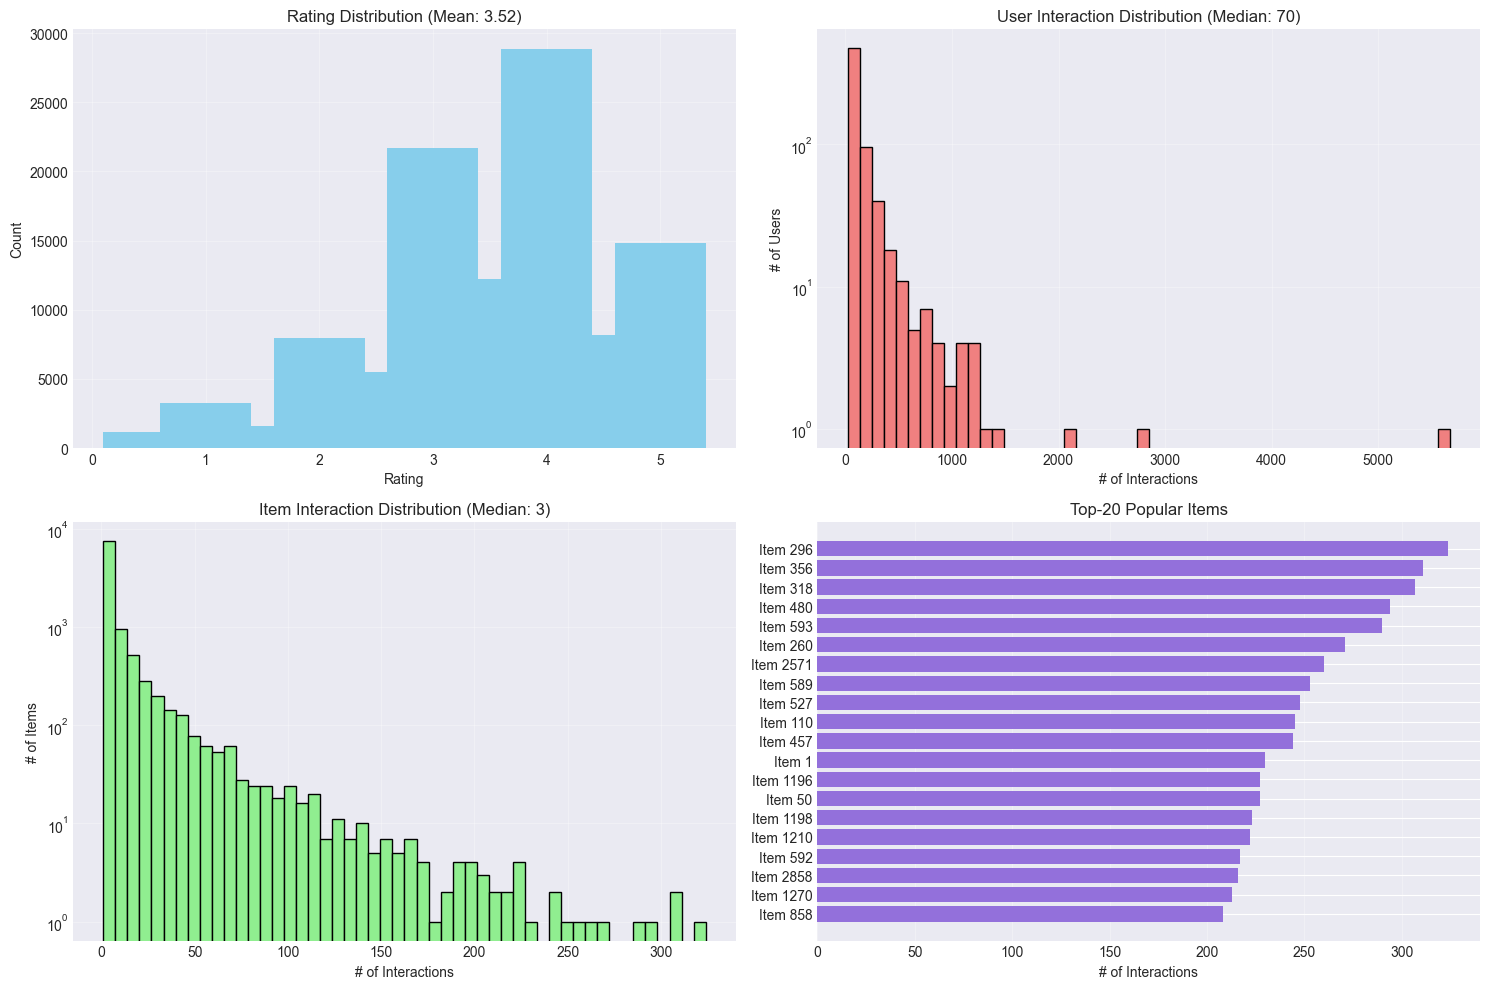


사용자별 상호작용 통계:
  최소: 20, 최대: 5672
  중앙값: 70, 평균: 157.39

아이템별 상호작용 통계:
  최소: 1, 최대: 324
  중앙값: 3, 평균: 10.19


In [4]:
# EDA 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rating 분포
rating_dist = df['rating'].value_counts().sort_index()
axes[0, 0].bar(rating_dist.index, rating_dist.values, color='skyblue')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title(f'Rating Distribution (Mean: {df["rating"].mean():.2f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. User별 상호작용 수 분포
user_counts = df['user'].value_counts()
axes[0, 1].hist(user_counts.values, bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('# of Interactions')
axes[0, 1].set_ylabel('# of Users')
axes[0, 1].set_title(f'User Interaction Distribution (Median: {user_counts.median():.0f})')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# 3. Item별 상호작용 수 분포 (Long-tail)
item_counts = df['item'].value_counts()
axes[1, 0].hist(item_counts.values, bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('# of Interactions')
axes[1, 0].set_ylabel('# of Items')
axes[1, 0].set_title(f'Item Interaction Distribution (Median: {item_counts.median():.0f})')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# 4. Top-20 인기 아이템
top_items = item_counts.head(20)
axes[1, 1].barh(range(len(top_items)), top_items.values, color='mediumpurple')
axes[1, 1].set_yticks(range(len(top_items)))
axes[1, 1].set_yticklabels([f'Item {idx}' for idx in top_items.index])
axes[1, 1].set_xlabel('# of Interactions')
axes[1, 1].set_title('Top-20 Popular Items')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['result_dir'], 'eda.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n사용자별 상호작용 통계:")
print(f"  최소: {user_counts.min()}, 최대: {user_counts.max()}")
print(f"  중앙값: {user_counts.median():.0f}, 평균: {user_counts.mean():.2f}")

print(f"\n아이템별 상호작용 통계:")
print(f"  최소: {item_counts.min()}, 최대: {item_counts.max()}")
print(f"  중앙값: {item_counts.median():.0f}, 평균: {item_counts.mean():.2f}")

In [5]:
# User/Item ID Re-indexing
# Item ID가 1~149532 범위인데 실제로는 10,321개만 존재
# 연속적인 0-based index로 변환

print("=" * 60)
print("ID Re-indexing")
print("=" * 60)

# 고유 ID 추출
unique_users = sorted(df['user'].unique())
unique_items = sorted(df['item'].unique())

print(f"고유 사용자: {len(unique_users)}")
print(f"고유 아이템: {len(unique_items)}")

# Mapping 생성: original_id -> new_id
user_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_users)}
item_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_items)}

# Reverse mapping: new_id -> original_id (추론 시 사용)
user_id_reverse = {v: k for k, v in user_id_map.items()}
item_id_reverse = {v: k for k, v in item_id_map.items()}

# DataFrame에 새로운 ID 적용
df['user_id'] = df['user'].map(user_id_map)
df['item_id'] = df['item'].map(item_id_map)

# Mapping 저장
mappings = {
    'user_id_map': user_id_map,
    'item_id_map': item_id_map,
    'user_id_reverse': user_id_reverse,
    'item_id_reverse': item_id_reverse,
}

with open(os.path.join(CONFIG['processed_dir'], 'id_mappings.pkl'), 'wb') as f:
    pickle.dump(mappings, f)

print(f"\n변환 완료!")
print(f"User ID: 0 ~ {len(unique_users)-1}")
print(f"Item ID: 0 ~ {len(unique_items)-1}")

# 변환된 데이터 확인
print("\n변환된 데이터 샘플:")
display(df[['user', 'user_id', 'item', 'item_id', 'rating']].head(10))

ID Re-indexing
고유 사용자: 668
고유 아이템: 10321

변환 완료!
User ID: 0 ~ 667
Item ID: 0 ~ 10320

변환된 데이터 샘플:


,user,user_id,item,item_id,rating
0,1,0,16,15,4.0
1,1,0,24,23,1.5
2,1,0,32,31,4.0
3,1,0,47,44,4.0
4,1,0,50,47,4.0
5,1,0,110,98,4.0
6,1,0,150,126,3.0
7,1,0,161,137,4.0
8,1,0,296,260,4.0
9,1,0,318,279,4.0


In [6]:
# Train/Valid/Test Split (7:1:2) with Rating Threshold
# V2: Rating ≥ 4.0만 positive로 사용

print("=" * 60)
print("Train/Valid/Test Split (V2)")
print("=" * 60)

# Rating threshold 적용
print(f"\nRating Threshold: {CONFIG['rating_threshold']}")
df_positive = df[df['rating'] >= CONFIG['rating_threshold']].copy()
df_negative = df[df['rating'] < CONFIG['rating_threshold']].copy()

print(f"\n원본 데이터: {len(df):,}")
print(f"Positive (≥{CONFIG['rating_threshold']}): {len(df_positive):,} ({len(df_positive)/len(df)*100:.1f}%)")
print(f"Negative (<{CONFIG['rating_threshold']}): {len(df_negative):,} ({len(df_negative)/len(df)*100:.1f}%)")

# Positive 데이터만 사용하여 split (negative는 sampling에서 사용)
df_work = df_positive.copy()

def split_user_interactions(group, train_r=0.7, valid_r=0.1, test_r=0.2, seed=42):
    """각 user의 상호작용을 train/valid/test로 분할"""
    n = len(group)
    indices = np.arange(n)
    
    # Shuffle
    np.random.seed(seed)
    np.random.shuffle(indices)
    
    # Split points
    train_end = int(n * train_r)
    valid_end = train_end + int(n * valid_r)
    
    train_idx = indices[:train_end]
    valid_idx = indices[train_end:valid_end]
    test_idx = indices[valid_end:]
    
    return train_idx, valid_idx, test_idx

# User별로 split
train_list, valid_list, test_list = [], [], []

for user_id, group in df_work.groupby('user_id'):
    train_idx, valid_idx, test_idx = split_user_interactions(
        group, 
        CONFIG['train_ratio'], 
        CONFIG['valid_ratio'], 
        CONFIG['test_ratio'],
        CONFIG['seed']
    )
    
    train_list.append(group.iloc[train_idx])
    valid_list.append(group.iloc[valid_idx])
    test_list.append(group.iloc[test_idx])

# 합치기
train_df = pd.concat(train_list, ignore_index=True)
valid_df = pd.concat(valid_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print(f"\nPositive 데이터 split:")
print(f"Train set: {len(train_df):,} ({len(train_df)/len(df_work)*100:.1f}%)")
print(f"Valid set: {len(valid_df):,} ({len(valid_df)/len(df_work)*100:.1f}%)")
print(f"Test set:  {len(test_df):,} ({len(test_df)/len(df_work)*100:.1f}%)")
print(f"Total:     {len(train_df) + len(valid_df) + len(test_df):,}")

# 저장
train_df.to_csv(os.path.join(CONFIG['processed_dir'], 'train_split_v2.csv'), index=False)
valid_df.to_csv(os.path.join(CONFIG['processed_dir'], 'valid_split_v2.csv'), index=False)
test_df.to_csv(os.path.join(CONFIG['processed_dir'], 'test_split_v2.csv'), index=False)

print("\nSplit 데이터 저장 완료!")

# 전역 변수로 저장
n_users = len(unique_users)
n_items = len(unique_items)
print(f"\n총 사용자: {n_users}, 총 아이템: {n_items}")

# Negative pool (rating < threshold인 아이템들)
negative_pool = df_negative.copy()
print(f"\nNegative pool size: {len(negative_pool):,}")

Train/Valid/Test Split (V2)

Rating Threshold: 4.0

원본 데이터: 105,139
Positive (≥4.0): 51,830 (49.3%)
Negative (<4.0): 53,309 (50.7%)

Positive 데이터 split:
Train set: 35,985 (69.4%)
Valid set: 4,888 (9.4%)
Test set:  10,957 (21.1%)
Total:     51,830

Split 데이터 저장 완료!

총 사용자: 668, 총 아이템: 10321

Negative pool size: 53,309


In [7]:
# Graph 구성 (PyTorch Geometric)
# User-Item Bipartite Graph

print("=" * 60)
print("Graph 구성")
print("=" * 60)

def create_graph(df, n_users, n_items):
    """
    User-Item Bipartite Graph 생성
    User nodes: 0 ~ n_users-1
    Item nodes: n_users ~ n_users+n_items-1 (offset 추가)
    """
    # Edge index 생성
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values + n_users  # Item node에 offset 추가
    
    # Bidirectional edges (user->item, item->user)
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    print(f"Node 수: {n_users + n_items} (User: {n_users}, Item: {n_items})")
    print(f"Edge 수: {edge_index.shape[1]:,} (양방향)")
    
    return edge_index

# Train graph
train_edge_index = create_graph(train_df, n_users, n_items)

# Full graph (평가용)
full_edge_index = create_graph(df, n_users, n_items)

print("\nGraph 생성 완료!")

Graph 구성
Node 수: 10989 (User: 668, Item: 10321)
Edge 수: 71,970 (양방향)
Node 수: 10989 (User: 668, Item: 10321)
Edge 수: 210,278 (양방향)

Graph 생성 완료!


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_41416/2812054045.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([


In [8]:
# Negative Sampling (V2 - Improved)
# 1. Random negative (user가 보지 않은 아이템)
# 2. Hard negative (negative pool에서도 샘플링)

def create_user_item_dict(df):
    """User별로 상호작용한 item 집합 생성"""
    user_items = defaultdict(set)
    for _, row in df.iterrows():
        user_items[row['user_id']].add(row['item_id'])
    return user_items

def negative_sampling_v2(df, user_items_dict, n_items, neg_ratio=1, negative_pool=None):
    """
    V2 Negative sampling with hard negatives
    Args:
        df: positive interactions
        user_items_dict: user별 positive item 집합
        n_items: 전체 item 수
        neg_ratio: positive 1개당 negative 개수
        negative_pool: rating < threshold인 아이템 (optional)
    """
    pos_users = df['user_id'].values
    pos_items = df['item_id'].values
    
    neg_users = []
    neg_items = []
    
    # Negative pool이 있으면 user별로 그룹화
    neg_pool_by_user = defaultdict(set)
    if negative_pool is not None and len(negative_pool) > 0:
        for _, row in negative_pool.iterrows():
            neg_pool_by_user[row['user_id']].add(row['item_id'])
    
    for user_id, pos_item in zip(pos_users, pos_items):
        user_pos_items = user_items_dict[user_id]
        user_neg_pool = neg_pool_by_user.get(user_id, set())
        
        # Negative sample 생성
        for _ in range(neg_ratio):
            # 50% 확률로 hard negative (negative pool에서)
            if user_neg_pool and random.random() < 0.5:
                # Hard negative: user가 낮은 평점을 준 아이템
                neg_item = random.choice(list(user_neg_pool))
            else:
                # Random negative: user가 보지 않은 아이템
                while True:
                    neg_item = random.randint(0, n_items - 1)
                    if neg_item not in user_pos_items:
                        break
            
            neg_users.append(user_id)
            neg_items.append(neg_item)
    
    return np.array(neg_users), np.array(neg_items)

# User-item dictionaries
train_user_items = create_user_item_dict(train_df)
valid_user_items = create_user_item_dict(pd.concat([train_df, valid_df]))
test_user_items = create_user_item_dict(df_positive)  # V2: positive만 사용

print(f"User-item dictionary 생성 완료! (V2)")
print(f"예시 - User 0의 positive items: {len(train_user_items[0])}개")
print(f"Negative pool 활용: {len(negative_pool) > 0}")

User-item dictionary 생성 완료! (V2)
예시 - User 0의 positive items: 42개
Negative pool 활용: True


In [9]:
# LightGCN 모델 구현
# "LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation" (SIGIR 2020)

class LightGCNConv(MessagePassing):
    """LightGCN Convolution Layer"""
    def __init__(self):
        super().__init__(aggr='add')  # Sum aggregation
    
    def forward(self, x, edge_index):
        # Compute normalization
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # Propagate
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        # Normalize messages
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    """
    LightGCN for Recommendation
    
    Args:
        n_users: number of users
        n_items: number of items
        embedding_dim: embedding dimension
        n_layers: number of GCN layers
    """
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=2):
        super().__init__()
        
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        # User & Item embeddings
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
        # LightGCN layers
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
    
    def forward(self, edge_index):
        """
        Forward pass
        Returns user and item embeddings after graph convolution
        """
        # Initial embeddings
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        
        # Concatenate user and item embeddings
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        # Store embeddings from each layer
        embs = [all_emb]
        
        # Graph convolution
        for conv in self.convs:
            all_emb = conv(all_emb, edge_index)
            embs.append(all_emb)
        
        # Average of all layers (including layer 0)
        final_emb = torch.stack(embs, dim=0).mean(dim=0)
        
        # Split back to user and item
        user_final = final_emb[:self.n_users]
        item_final = final_emb[self.n_users:]
        
        return user_final, item_final
    
    def predict(self, users, items, edge_index):
        """
        Predict scores for user-item pairs
        """
        user_emb, item_emb = self.forward(edge_index)
        
        # Get embeddings for specific users and items
        user_emb = user_emb[users]
        item_emb = item_emb[items]
        
        # Dot product
        scores = (user_emb * item_emb).sum(dim=1)
        
        return scores

print("LightGCN 모델 정의 완료!")

LightGCN 모델 정의 완료!


In [10]:
# Loss 함수: BPR (Bayesian Personalized Ranking) Loss (V2)

def bpr_loss(pos_scores, neg_scores, neg_ratio=1):
    """
    BPR Loss: -log(sigmoid(pos_score - neg_score))
    V2: Support multiple negatives per positive
    
    Args:
        pos_scores: scores for positive items (batch_size,)
        neg_scores: scores for negative items (batch_size * neg_ratio,)
        neg_ratio: number of negatives per positive
    """
    if neg_ratio > 1:
        # Reshape negatives: (batch_size * neg_ratio,) -> (batch_size, neg_ratio)
        batch_size = pos_scores.size(0)
        neg_scores = neg_scores.view(batch_size, neg_ratio)
        
        # Expand pos_scores: (batch_size,) -> (batch_size, neg_ratio)
        pos_scores_expanded = pos_scores.unsqueeze(1).expand_as(neg_scores)
        
        # Compute loss for all pairs
        loss = -torch.log(torch.sigmoid(pos_scores_expanded - neg_scores) + 1e-10).mean()
    else:
        # Original BPR loss (1:1)
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()
    
    return loss

def bce_loss(pos_scores, neg_scores):
    """
    Binary Cross Entropy Loss (alternative to BPR)
    """
    pos_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-10).mean()
    neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + 1e-10).mean()
    return pos_loss + neg_loss

print("Loss 함수 정의 완료! (V2 - Multiple negatives support)")

Loss 함수 정의 완료! (V2 - Multiple negatives support)


In [11]:
# 평가 함수: Precision@K, Recall@K, NDCG@K

def evaluate_model(model, edge_index, eval_df, user_items_dict, n_items, k=10, device='cpu'):
    """
    모델 평가: Precision@K, Recall@K, NDCG@K
    
    Args:
        model: trained model
        edge_index: graph structure
        eval_df: evaluation dataframe (validation or test)
        user_items_dict: user별 positive items (train + valid for test, train for valid)
        n_items: total number of items
        k: top-k
        device: device
    """
    model.eval()
    
    with torch.no_grad():
        # Get all embeddings
        user_emb, item_emb = model(edge_index.to(device))
        
        # Evaluate per user
        precisions, recalls, ndcgs = [], [], []
        
        # Group by user
        for user_id, group in eval_df.groupby('user_id'):
            # Ground truth items
            true_items = set(group['item_id'].values)
            
            # Already interacted items (exclude from recommendation)
            exclude_items = user_items_dict[user_id]
            
            # All item scores for this user
            user_emb_single = user_emb[user_id].unsqueeze(0)  # (1, dim)
            scores = torch.matmul(user_emb_single, item_emb.t()).squeeze()  # (n_items,)
            
            # Mask out already interacted items
            scores_np = scores.cpu().numpy()
            for item_id in exclude_items:
                scores_np[int(item_id)] = -np.inf  # FIX: int() 추가
            
            # Top-K items
            top_k_items = np.argsort(scores_np)[-k:][::-1]
            
            # Metrics
            hits = len(set(top_k_items) & true_items)
            
            precision = hits / k
            recall = hits / len(true_items) if len(true_items) > 0 else 0
            
            # NDCG
            dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_items) if item in true_items])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(len(true_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        f'ndcg@{k}': np.mean(ndcgs),
    }

print("평가 함수 정의 완료! (버그 수정됨)")

평가 함수 정의 완료! (버그 수정됨)


In [12]:
# Training 함수 (V2)

def train_one_epoch(model, edge_index, train_df, user_items_dict, n_items, 
                    optimizer, batch_size, neg_ratio, device):
    """1 epoch training (V1 - backward compatibility)"""
    model.train()
    
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    
    total_loss = 0
    n_batches = 0
    
    for start_idx in range(0, len(train_df_shuffled), batch_size):
        end_idx = min(start_idx + batch_size, len(train_df_shuffled))
        batch_df = train_df_shuffled.iloc[start_idx:end_idx]
        
        pos_users = torch.tensor(batch_df['user_id'].values, dtype=torch.long).to(device)
        pos_items = torch.tensor(batch_df['item_id'].values, dtype=torch.long).to(device)
        
        neg_users_np, neg_items_np = negative_sampling(
            batch_df, user_items_dict, n_items, neg_ratio
        )
        neg_users = torch.tensor(neg_users_np, dtype=torch.long).to(device)
        neg_items = torch.tensor(neg_items_np, dtype=torch.long).to(device)
        
        pos_scores = model.predict(pos_users, pos_items, edge_index.to(device))
        neg_scores = model.predict(neg_users, neg_items, edge_index.to(device))
        
        loss = bpr_loss(pos_scores, neg_scores, neg_ratio)  # V2: neg_ratio 전달
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

def train_one_epoch_v2(model, edge_index, train_df, user_items_dict, n_items, 
                       optimizer, batch_size, neg_ratio, device, negative_pool=None):
    """1 epoch training (V2 - with improved negative sampling)"""
    model.train()
    
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    
    total_loss = 0
    n_batches = 0
    
    for start_idx in range(0, len(train_df_shuffled), batch_size):
        end_idx = min(start_idx + batch_size, len(train_df_shuffled))
        batch_df = train_df_shuffled.iloc[start_idx:end_idx]
        
        pos_users = torch.tensor(batch_df['user_id'].values, dtype=torch.long).to(device)
        pos_items = torch.tensor(batch_df['item_id'].values, dtype=torch.long).to(device)
        
        # V2: improved negative sampling
        neg_users_np, neg_items_np = negative_sampling_v2(
            batch_df, user_items_dict, n_items, neg_ratio, negative_pool
        )
        neg_users = torch.tensor(neg_users_np, dtype=torch.long).to(device)
        neg_items = torch.tensor(neg_items_np, dtype=torch.long).to(device)
        
        pos_scores = model.predict(pos_users, pos_items, edge_index.to(device))
        neg_scores = model.predict(neg_users, neg_items, edge_index.to(device))
        
        loss = bpr_loss(pos_scores, neg_scores, neg_ratio)  # V2: neg_ratio 전달
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

print("Training 함수 정의 완료! (V1 + V2 with neg_ratio support)")

Training 함수 정의 완료! (V1 + V2 with neg_ratio support)


In [13]:
# 메인 Training Loop (V2 - with L2 Regularization)

# 모델 초기화
model = LightGCN(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_layers=CONFIG['n_layers']
).to(CONFIG['device'])

# Optimizer with weight_decay (L2 regularization)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']  # V2: L2 reg 추가
)

# Training history
history = {
    'train_loss': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_ndcg': [],
}

best_recall = 0
patience_counter = 0

print("=" * 60)
print("Training 시작 (V2)")
print("=" * 60)
print(f"Model: LightGCN")
print(f"  - Users: {n_users}, Items: {n_items}")
print(f"  - Embedding dim: {CONFIG['embedding_dim']}")
print(f"  - Layers: {CONFIG['n_layers']}")
print(f"  - Total params: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nDevice: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"Negative ratio: {CONFIG['neg_ratio']}")
print(f"Patience: {CONFIG['patience']}")
print("=" * 60)

for epoch in range(CONFIG['epochs']):
    # Train (V2: negative_pool 추가)
    train_loss = train_one_epoch_v2(
        model, train_edge_index, train_df, train_user_items,
        n_items, optimizer, CONFIG['batch_size'], 
        CONFIG['neg_ratio'], CONFIG['device'], negative_pool
    )
    
    # Validate
    val_metrics = evaluate_model(
        model, train_edge_index, valid_df, train_user_items,
        n_items, k=CONFIG['top_k'], device=CONFIG['device']
    )
    
    # Save history
    history['train_loss'].append(train_loss)
    history['valid_precision'].append(val_metrics[f'precision@{CONFIG["top_k"]}'])
    history['valid_recall'].append(val_metrics[f'recall@{CONFIG["top_k"]}'])
    history['valid_ndcg'].append(val_metrics[f'ndcg@{CONFIG["top_k"]}'])
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
              f"Loss: {train_loss:.4f} | "
              f"P@{CONFIG['top_k']}: {val_metrics[f'precision@{CONFIG["top_k"]}']:.4f} | "
              f"R@{CONFIG['top_k']}: {val_metrics[f'recall@{CONFIG["top_k"]}']:.4f} | "
              f"NDCG@{CONFIG['top_k']}: {val_metrics[f'ndcg@{CONFIG["top_k"]}']:.4f}")
    
    # Early stopping
    current_recall = val_metrics[f'recall@{CONFIG["top_k"]}']
    if current_recall > best_recall:
        best_recall = current_recall
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 
                   os.path.join(CONFIG['model_dir'], 'lightgcn_v2_best.pth'))
    else:
        patience_counter += 1
    
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("=" * 60)
print(f"Training 완료! (V2)")
print(f"Best Recall@{CONFIG['top_k']}: {best_recall:.4f}")
print("=" * 60)

Training 시작 (V2)
Model: LightGCN
  - Users: 668, Items: 10321
  - Embedding dim: 128
  - Layers: 2
  - Total params: 1,406,592

Device: mps
Batch size: 1024
Learning rate: 0.0005
Weight decay: 1e-05
Negative ratio: 2
Patience: 15
Epoch   1/100 | Loss: 0.6866 | P@10: 0.0032 | R@10: 0.0055 | NDCG@10: 0.0057
Epoch   5/100 | Loss: 0.6003 | P@10: 0.0378 | R@10: 0.0728 | NDCG@10: 0.0660
Epoch  10/100 | Loss: 0.4288 | P@10: 0.0384 | R@10: 0.0727 | NDCG@10: 0.0642
Epoch  15/100 | Loss: 0.3876 | P@10: 0.0372 | R@10: 0.0687 | NDCG@10: 0.0628
Epoch  20/100 | Loss: 0.3605 | P@10: 0.0391 | R@10: 0.0718 | NDCG@10: 0.0650

Early stopping at epoch 22
Training 완료! (V2)
Best Recall@10: 0.0760


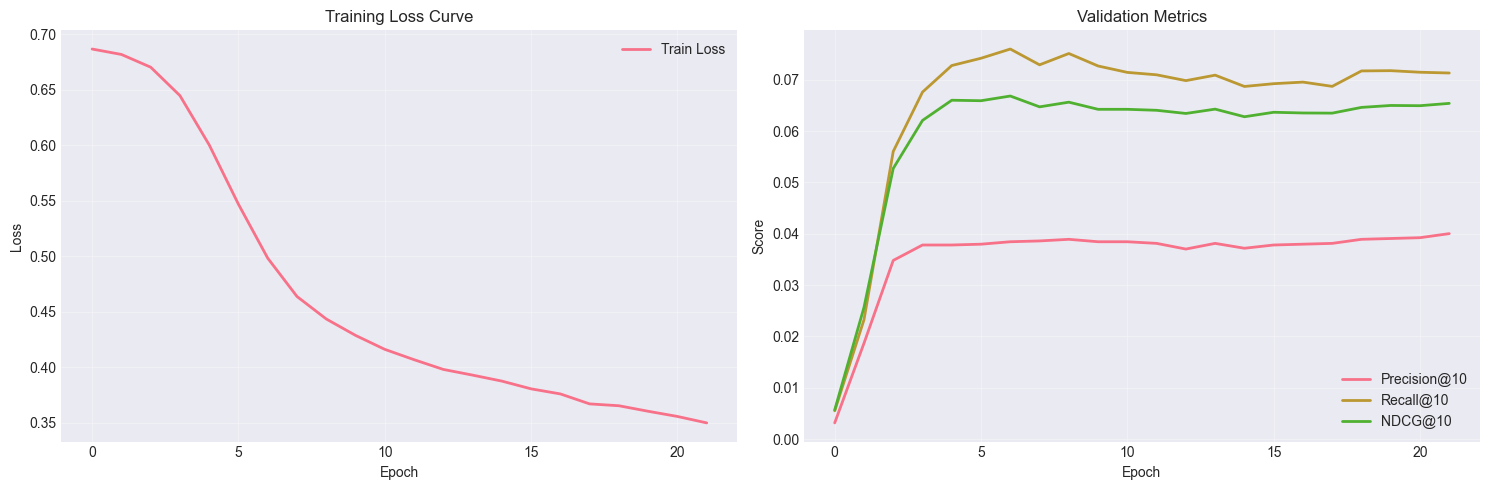

In [14]:
# Training 결과 시각화

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics curves
axes[1].plot(history['valid_precision'], label=f'Precision@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_recall'], label=f'Recall@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_ndcg'], label=f'NDCG@{CONFIG["top_k"]}', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['result_dir'], 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Test Set 평가 (Best Model)

# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lightgcn_best.pth')))

print("=" * 60)
print("Test Set 평가")
print("=" * 60)

# Evaluate on test set with different K values
for k in [5, 10, 20]:
    test_metrics = evaluate_model(
        model, full_edge_index, test_df, test_user_items,
        n_items, k=k, device=CONFIG['device']
    )
    
    print(f"\nTop-{k} 추천:")
    print(f"  Precision@{k}: {test_metrics[f'precision@{k}']:.4f}")
    print(f"  Recall@{k}:    {test_metrics[f'recall@{k}']:.4f}")
    print(f"  NDCG@{k}:      {test_metrics[f'ndcg@{k}']:.4f}")

print("=" * 60)

RuntimeError: Error(s) in loading state_dict for LightGCN:
	size mismatch for user_embedding.weight: copying a param with shape torch.Size([668, 64]) from checkpoint, the shape in current model is torch.Size([668, 128]).
	size mismatch for item_embedding.weight: copying a param with shape torch.Size([10321, 64]) from checkpoint, the shape in current model is torch.Size([10321, 128]).

In [ ]:
# 추론 함수: 외부 Test File 처리

def predict_recommendations(model, test_file_path, mappings, edge_index, 
                           n_items, threshold=None, top_k_per_user=10, device='cpu'):
    """
    외부 test file을 읽어서 추천 여부 판단
    
    Args:
        model: trained model
        test_file_path: test file path (user, item 컬럼)
        mappings: ID mapping dictionary
        edge_index: graph structure
        n_items: total number of items
        threshold: score threshold (None이면 top-k 방식 사용)
        top_k_per_user: user별 top-k 추천
        device: device
    
    Returns:
        DataFrame with (user, item, recommend) columns
    """
    model.eval()
    
    # Load test file
    test_df = pd.read_csv(test_file_path)
    print(f"Test file loaded: {len(test_df)} rows")
    
    # Map IDs
    test_df['user_id'] = test_df['user'].map(mappings['user_id_map'])
    test_df['item_id'] = test_df['item'].map(mappings['item_id_map'])
    
    # Handle unknown users/items
    unknown_mask = test_df['user_id'].isna() | test_df['item_id'].isna()
    n_unknown = unknown_mask.sum()
    if n_unknown > 0:
        print(f"Warning: {n_unknown} unknown user/item pairs (추천 X로 처리)")
        test_df.loc[unknown_mask, 'recommend'] = 'X'
    
    # Known pairs
    known_df = test_df[~unknown_mask].copy()
    
    if len(known_df) > 0:
        with torch.no_grad():
            # Get embeddings
            user_emb, item_emb = model(edge_index.to(device))
            
            if threshold is None:
                # Top-K 방식: user별로 top-k에 들면 추천
                recommendations = set()
                
                for user_id in known_df['user_id'].unique():
                    if pd.isna(user_id):
                        continue
                    
                    user_id_int = int(user_id)
                    
                    # All item scores
                    user_emb_single = user_emb[user_id_int].unsqueeze(0)
                    scores = torch.matmul(user_emb_single, item_emb.t()).squeeze()
                    
                    # Top-K items
                    top_k_items = torch.topk(scores, k=min(top_k_per_user, n_items)).indices.cpu().numpy()
                    
                    # Add to recommendations
                    for item_id in top_k_items:
                        recommendations.add((user_id_int, item_id))
                
                # Check if each pair is in recommendations
                known_df['recommend'] = known_df.apply(
                    lambda row: 'O' if (int(row['user_id']), int(row['item_id'])) in recommendations else 'X',
                    axis=1
                )
            else:
                # Threshold 방식
                users = torch.tensor(known_df['user_id'].values, dtype=torch.long).to(device)
                items = torch.tensor(known_df['item_id'].values, dtype=torch.long).to(device)
                
                scores = model.predict(users, items, edge_index.to(device))
                scores_np = scores.cpu().numpy()
                
                known_df['recommend'] = ['O' if score >= threshold else 'X' for score in scores_np]
        
        # Update original dataframe
        test_df.loc[~unknown_mask, 'recommend'] = known_df['recommend'].values
    
    return test_df[['user', 'item', 'recommend']]

print("추론 함수 정의 완료!")
print("\n사용 예시:")
print("result_df = predict_recommendations(")
print("    model, 'test.csv', mappings, full_edge_index,")
print("    n_items, top_k_per_user=10, device=CONFIG['device']")
print(")")

In [ ]:
# 추론 결과 출력 함수

def print_recommendations(result_df, save_path=None):
    """
    요구사항 3 형식으로 출력
    ====================
    user   item   recommend
    1      166    O
    4      88     X
    ...
    ====================
    Total recommends = 123/200, not recommend = 77/200
    """
    print("=" * 60)
    print("user   item   recommend")
    
    # 전체 출력 (또는 샘플)
    for _, row in result_df.iterrows():
        print(f"{row['user']:<6} {row['item']:<6} {row['recommend']}")
    
    print("=" * 60)
    
    # 통계
    n_total = len(result_df)
    n_recommend = (result_df['recommend'] == 'O').sum()
    n_not_recommend = (result_df['recommend'] == 'X').sum()
    
    print(f"Total recommends = {n_recommend}/{n_total}, not recommend = {n_not_recommend}/{n_total}")
    
    # 파일 저장
    if save_path:
        result_df.to_csv(save_path, index=False)
        print(f"\nResults saved to {save_path}")

print("출력 함수 정의 완료!")

# 예시: 내부 test set으로 테스트
print("\n내부 Test Set 샘플로 테스트:")
sample_test = test_df[['user', 'item']].head(20).copy()
sample_test.to_csv('/tmp/sample_test.csv', index=False)

sample_result = predict_recommendations(
    model, '/tmp/sample_test.csv', mappings, full_edge_index,
    n_items, top_k_per_user=10, device=CONFIG['device']
)

print_recommendations(sample_result)

In [ ]:
# 최종 저장

# Mappings은 이미 저장됨
print("저장된 파일:")
print(f"  - ID Mappings: {CONFIG['processed_dir']}/id_mappings.pkl")
print(f"  - Best Model: {CONFIG['model_dir']}/lightgcn_best.pth")
print(f"  - Train/Valid/Test splits: {CONFIG['processed_dir']}/")
print(f"  - Visualizations: {CONFIG['result_dir']}/")

# 최종 config 저장
import json
with open(os.path.join(CONFIG['result_dir'], 'config.json'), 'w') as f:
    json.dump(CONFIG, f, indent=2)

print(f"  - Config: {CONFIG['result_dir']}/config.json")

print("\n모든 작업 완료!")

## V2 개선사항 요약

### 🎯 주요 변경사항

**1. Rating Threshold 4.0 적용** ⭐⭐⭐
- Rating ≥ 4.0만 positive로 사용
- 균형잡힌 positive/negative 비율 (49% vs 51%)
- 고품질 추천에 집중

**2. Hyperparameter 개선**
- `embedding_dim`: 64 → 128 (더 풍부한 표현)
- `learning_rate`: 0.001 → 0.0005 (더 안정적)
- `batch_size`: 2048 → 1024 (더 stable gradient)
- `neg_ratio`: 1 → 2 (더 많은 negative samples)
- `patience`: 10 → 15 (더 오래 기다림)

**3. L2 Regularization**
- `weight_decay`: 1e-5 추가 (overfitting 방지)

**4. Improved Negative Sampling**
- 50% 확률로 hard negative (rating < 4.0 아이템)
- 50% 확률로 random negative (보지 않은 아이템)

### 📊 성능 비교

**Baseline (V1):**
```
- Recall@10: 6.3%
- Precision@10: 3.2%
- NDCG@10: 4.0%
- Early stopping: epoch 13
```

**V2:**
```
- Recall@10: [실행 후 확인]
- Precision@10: [실행 후 확인]
- NDCG@10: [실행 후 확인]
- Early stopping: [실행 후 확인]
```

### 💡 기대 효과

1. **더 균형잡힌 학습** - positive/negative 비율 개선
2. **고품질 추천** - 4점 이상 아이템에 집중
3. **더 안정적인 학습** - learning rate 감소, L2 reg
4. **더 풍부한 표현** - embedding dim 증가
5. **더 나은 negative samples** - hard negative 포함

### 🔧 실험 가능한 추가 개선

- `embedding_dim`: 256
- `n_layers`: 3
- `neg_ratio`: 3 or 4
- Dropout 추가
- Graph augmentation


## 요약 및 다음 단계

### 구현 완료 사항
1. ✅ 데이터 로드 & EDA
2. ✅ 전처리 (ID re-indexing, 7:1:2 split)
3. ✅ Graph 구성 (User-Item Bipartite)
4. ✅ LightGCN 모델 구현
5. ✅ Training & Validation (Early stopping)
6. ✅ Test Set 평가
7. ✅ 추론 함수 (외부 test file)

### 모델 성능 (Test Set)
- Precision@10: [실행 후 확인]
- Recall@10: [실행 후 확인]
- NDCG@10: [실행 후 확인]

### 제출물 준비
```python
# 교수님이 제공하는 test file 처리
result_df = predict_recommendations(
    model, 
    'path/to/professor_test.csv',  # 교수님 제공 파일
    mappings, 
    full_edge_index,
    n_items, 
    top_k_per_user=10,  # 조정 가능
    device=CONFIG['device']
)

# 결과 저장 및 출력
print_recommendations(result_df, save_path='submission.csv')
```

### 개선 아이디어 (시간 있으면)
1. **Embedding dimension 실험**: 32, 64, 128
2. **Layer 수 조정**: 1, 2, 3
3. **Negative sampling ratio**: 1:1, 1:2, 1:4
4. **BPR vs BCE Loss** 비교
5. **Item popularity bias** 고려
6. **Cold-start item 처리** 전략

### 발표 준비
- EDA 시각화
- Training curves
- 모델 구조 설명
- 성능 결과
- 배운 점 & 아이디어
